In [4]:
using Plots; gr()
using NLsolve
using LaTeXStrings
using LinearAlgebra


chi = 1.5                  # Scale parameter of labor
psi = 1.0                  # Elasticity of labor
rho = 1.01                 # Elasiticty of consumption
beta= 0.9

phi = range(0,             # Lagrange multiplier of the implementability constraint
            stop=1,
            length=30)     

G   = [0.1 0.2]'           # State-space of government expenditures

Pi  = [0.9 0.1;            # Markov transition matrix
       0.5 0.5];

## Part One
## Question A

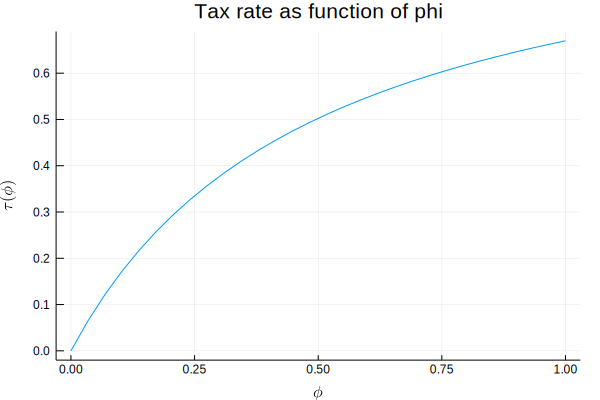

In [5]:
function tau(phi)
    1 .- (1 .+ phi .* (1 - rho)) ./ (1 .+ phi .* (1 + psi))
end

plot(phi, tau(phi),
     title="Tax rate as function of phi",
     label="",
     xlabel=L"$\phi$",
     ylabel=L"$\tau(\phi)$")

## Question B

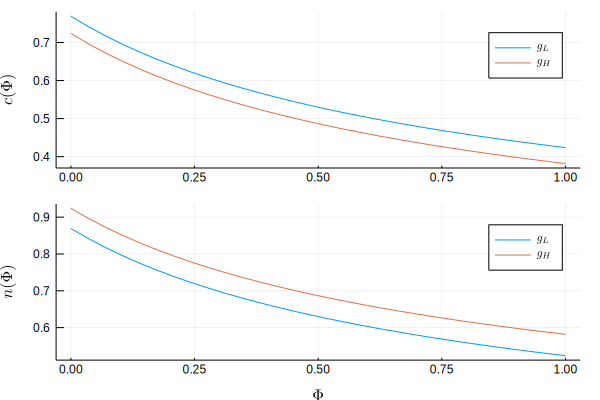

In [6]:
"""
Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi
"""
function timeInvariantAllocationSolver(g, phi)

    function f!(F, x)
        F[1] = x[1] - x[2] + g
        F[2] = x[1]^(- rho) * (1 + phi * (1 - rho)) - chi * x[2]^(psi) * (1 + phi * (1 + psi))
    end

    function j!(J, x)
        J[1, 1] = 1
        J[1, 2] = -1
        J[2, 1] = - rho * x[1]^(- rho - 1) * (1 + phi * (1 - rho))
        J[2, 2] = - chi * psi * x[2]^(psi - 1) * (1 + phi * (1 + psi))
    end

    nlsolve(f!, j!, [0.1; 0.1])
end

"""
Compute the time invariant allocation for a given set of governement expenditures and lagrange multiplier

Arguments:
    G: a vector of possible values for the government expenditures
    phi: a vector of possible values for phi

Return:
    (C, N): a tuple of matrices where X[i, j] is the time invariant allocation of X for g[i] and phi[j]
"""
function timeInvariantAllocation(G, phi)
    C = zeros(length(G), length(phi))
    N = zeros(length(G), length(phi))

    for (i, g) in enumerate(G)
        for (j, phi) in enumerate(phi)
            roots   = timeInvariantAllocationSolver(g, phi).zero
            C[i, j] = roots[1]
            N[i, j] = roots[2]
        end
    end

    return (C', N')
end

C, N = timeInvariantAllocation(G, phi)

plot(layout=(2,1),
    
    plot(phi, C,
        label=[L"g_L" L"g_H"],
        ylabel=L"$c(\Phi)$"
        ),
    
    plot(phi, N,
        label=[L"g_L" L"g_H"],
        ylabel=L"$n(\Phi)$",
        xlabel=L"$\Phi$"
        )
)

## Question C

From the IC we have
$$
u_c(g)c(g) - u_x(g)(1-x(g)) + \beta \sum_{g'} \Pi(g'|g) u_c(g') b(g') - u_c(g)b(g) = 0
$$

In [7]:
"""
Compute a vector of marginal utilites for all states

Arguments:
    C  (ndArray): Matrix of consumption for each combination of g and phi
    N  (ndArray): Matrix of labor for each combination of g and phi

"""
function marginalUtilities(c, n)
    Uc = c.^(-rho)
    Un = -chi .* n .^ psi
    
    return (Uc, Un)
end

"""
Gives the debt policy of the government in function of the expenditures and the lagrange multiplier
"""
function bonds(Nstates, Nphi, C, N, Uc, Un, Pi, beta)
    b = zeros(Nstates, Nphi)
    Id = Matrix{Float64}(I, Nstates, Nstates)
    for i in 1:Nphi
        c = C[i,:]
        n = N[i,:]
        uc = Uc[i,:]
        un = Un[i,:]
        
        # The system writes:
        # b = Ab + E
        A  = beta .* (1 ./ uc) * uc' .* Pi
        E  = c .+ un./uc .* n
        
        b[:,i] = inv(Id - A) * E # We solve the system for a given phi
    end
    
    return b
end

bonds

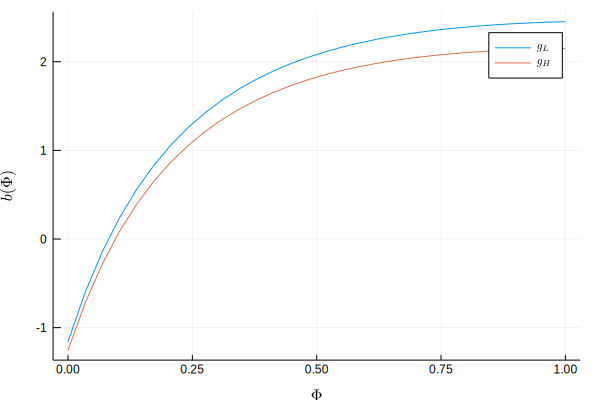

In [9]:
Uc, Un = marginalUtilities(C,N)
B = bonds(length(G), length(phi), C, N, Uc, Un, Pi, beta)';

plot(phi, B,
    xlabel=L"$\Phi$",
    ylabel=L"$b(\Phi)$",
    label=[L"$g_L$", L"$g_H$"])

# Part two

## Question A


In [10]:
function timeZeroIC(c, x, phi, b0)
    Uc  = c ^ (- rho)
    Ucc = - rho * c ^ (-rho - 1)
    Ux  = chi * (1 - x) ^ psi
    Uxx = - chi * psi * (1 - x) ^ (psi - 1)
    
    return (1 + phi) * (Uc - Ux) + phi * (c - b0 * Ucc) + phi * (1 - x) * Uxx
end

timeZeroIC (generic function with 1 method)

In [11]:
"""
Solves the time invariant allocation for a given government expenditure g and lagrange multiplier phi
"""
function timeZeroAllocationSolver(g, phi, b0)

    function f!(F, x)
        Uc  = x[1] ^ (- rho)
        Ucc = - rho * x[1] ^ (-rho - 1)
        Ux  = chi * (1 - x[2]) ^ psi
        Uxx = - chi * psi * (1 - x[2]) ^ (psi - 1)
        F[1] = x[1] + g - (1 - x[2])
        F[2] = (1 + phi) * (Uc - Ux) + phi * (x[1] - b0 * Ucc) + phi * (1 - x[2]) * Uxx
    end

    nlsolve(f!, [0.5; 0.5])
end

function timeZeroAllocation(g, phi, b0)
    C0 = zeros(length(phi), length(b0))
    N0 = zeros(length(phi), length(b0))
    
    for (i, phi) in enumerate(phi)
        for (j, b0) in enumerate(b0)
            roots   = timeZeroAllocationSolver(g, phi, b0).zero
            C0[i, j] = roots[1]
            N0[i, j] = 1 - roots[2]
        end
    end
    
    return (C0, N0)
end

timeZeroAllocation (generic function with 1 method)

In [27]:
plotly()
b0 = range(-0.1, stop=0.1, length=10)

C0, N0 = timeZeroAllocation(G[1], phi, b0)

plot(b0, phi, C0, linetype=:surface,
    xlabel= "b0",
    ylabel= "phi",
    zlabel= "C0")

## Question B

In [174]:
function bisec(f::Function, b0, a, b, tol::AbstractFloat=1e-5, maxiter::Integer=100)
    fa = f(a, b0)
    fa*f(b, b0) <= 0 || error("No real root in [a,b]")
    i = 0
    local c
    while b-a > tol
        i += 1
        i != maxiter || error("Max iteration exceeded")
        c = (a+b)/2
        fc = f(c, b0)
        if fc == 0
            break
        elseif fa*fc > 0
            a = c  # Root is in the right half of [a,b].
            fa = fc
        else
            b = c  # Root is in the left half of [a,b].
        end
    end
    return c
end

bisec (generic function with 6 methods)

In [207]:
function timeZeroICTwo(phi, b0)
    c0, n0 = timeZeroAllocationSolver(G[1], phi, b0).zero
    x0 = 1-n0
    Uc  = c0 ^ (- rho)
    Ucc = - rho * c0 ^ (-rho - 1)
    Ux  = chi * (1 - x0) ^ psi
    Uxx = - chi * psi * (1 - x0) ^ (psi - 1)
    (1 + phi) * (Uc - Ux) + phi * (c0 - b0 * Ucc) + phi * (1 - x0) * Uxx
end

timeZeroICTwo (generic function with 1 method)

In [237]:
function eqtosolve(phi, b0)
    c0, n0 = timeZeroAllocationSolver(G[1], phi, b0).zero
    x0 = 1 - n0
    Uc  = c0 ^ (- rho)
    Ucc = - rho * c0 ^ (-rho - 1)
    Ux  = chi * (1 - x0) ^ psi
    Uxx = - chi * psi * (1 - x0) ^ (psi - 1)
    return b0 - (((1 + phi) * (Uc - Ux) + phi * (c0 + (1 - x0) * Uxx)) / (phi * Ucc))
end

eqtosolve (generic function with 1 method)

In [222]:
b0_vec = range(-0.1, stop=0.1, length= 98)
b0 = 0.1
println(timeZeroICTwo(0, b0), "  <->   ", timeZeroICTwo(1, b0))

1.1072897710434626  <->   2.8940346189903203


In [175]:
bisec(timeZeroICTwo, 0.01, 0, 1)

ErrorException: No real root in [a,b]

In [244]:
eqtosolve(,0.1)

0.8036944457864604